In [ ]:
import argparse
import csv
import hashlib
import itertools
import json
import os
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import S4
import torch
from scipy.interpolate import CubicSpline
from matplotlib.colors import ListedColormap

# =============================================================================
# Configuration parameters for the simulation.
# =============================================================================
config = {
    "seeds": {"torch": 42, "numpy": 42},
    "off_angle": 0.0,
    "square_x_location": 0.15,
    "square_y_location": 0.15,
    "polarization_angle": 45,
    "square_half_widths": 0.15,
    "wavelength_start_index": 0,
    "wavelength_end_index": 2649,
    "measurement_location": 5,
}

save = False

# =============================================================================
# Define the common simulation parameters.
# Top row: z-domain is -0.50 to 1.50 µm.
# Lower plots: data for 0.00 to 1.50 µm.
# =============================================================================
z_min = -0.5
z_max = 1.5
n_z_points = 100  # number of grid points in z
z_space = np.linspace(z_min, z_max, n_z_points)
# For lower plots, only use data for z >= 0.
indices = z_space >= 0
z_space_other = z_space[indices]

x_space = np.linspace(0, 0.6, 100)  # x-domain remains unchanged

# =============================================================================
# Load material data and set up the simulation.
# =============================================================================
wavelengths = torch.linspace(0.350, 3, 2651)
wavelengths = wavelengths[(wavelengths != 0.5) & (wavelengths != 1.0)]

n_all = np.load('/home/rliacobacci/Downloads/n_allHTMats.npz')
k_all = np.load('/home/rliacobacci/Downloads/k_allHTMats.npz')

def load_refractive_index_file(filepath):
    """Load refractive index data from a file with columns 'wl n'."""
    wl_list, n_list = [], []
    with open(filepath, "r") as f:
        f.readline()  # skip header
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) != 2:
                continue
            wl, n_val = parts
            wl_list.append(float(wl))
            n_list.append(float(n_val))
    return np.array(wl_list), np.array(n_list)

def interpolate_refractive_indices(filepath):
    """Interpolate refractive indices over 350 nm to 3000 nm."""
    orig_wl, orig_n = load_refractive_index_file(filepath)
    new_wl_nm = np.arange(350, 3001)  # nm
    new_wl_microns = new_wl_nm / 1000.0
    cs = CubicSpline(orig_wl, orig_n)
    new_n = cs(new_wl_microns)
    return {wl: n_val for wl, n_val in zip(new_wl_nm, new_n)}

y_pt = .3
SiO2_n = interpolate_refractive_indices('/home/rliacobacci/Downloads/SiO2_n.txt')
i = 1480
wavelength = wavelengths[i]
p = 0.6  # lattice period

w_n = n_all['arr_0'][:, -1] + k_all['arr_0'][:, -1] * 1j
aln_n = n_all['arr_0'][:, 17] + k_all['arr_0'][:, 17] * 1j

harmonics = 400 # 70 is sufficient for electric field calulation in the grid structure layer
# Initialize the S4 simulation object.
S = S4.New(Lattice=((p, 0), (0, p)), NumBasis=harmonics)

S.SetMaterial(Name='AluminumNitride', Epsilon=(aln_n[i])**2)
S.SetMaterial(Name='Tungsten', Epsilon=(w_n[i])**2)
S.SetMaterial(Name='Vacuum', Epsilon=(1 + 0j)**2)
S.SetMaterial(Name='SiliconDioxide', Epsilon=(SiO2_n[int(wavelength * 1e3)]**2))

# Define the layered structure.
S.AddLayer(Name='AirAbove', Thickness=1, Material='Vacuum')
S.AddLayer(Name='TungstenGrid', Thickness=0.06, Material='Vacuum')
S.SetRegionRectangle(
    Layer='TungstenGrid',
    Material='Tungsten',
    Center=(config['square_x_location'] + config['square_half_widths'],
            config['square_y_location'] + config['square_half_widths']),
    Halfwidths=(config['square_half_widths'], 2*config['square_half_widths']),
    Angle=0,
)
S.AddLayer(Name='SiliconDioxide', Thickness=0.06, Material='SiliconDioxide')
S.AddLayer(Name='TungstenBelow', Thickness=1, Material='Tungsten')
S.AddLayer(Name='AirBelow', Thickness=1, Material='Vacuum')

S.SetExcitationPlanewave(
    IncidenceAngles=(config['off_angle'], 0),
    sAmplitude=np.cos(config['polarization_angle'] * np.pi / 180),
    pAmplitude=np.sin(config['polarization_angle'] * np.pi / 180),
    Order=0,
)
S.SetOptions(PolarizationDecomposition=True)
S.SetFrequency(1 / float(wavelength))

# =============================================================================
# Field mapping: Compute the electric field on the (x, z) grid.
# Use GetField at every point instead of GetFieldsOnGrid
# =============================================================================
electric_field = np.zeros((len(z_space), len(x_space), 3), dtype=complex)
# for zi, z in enumerate(z_space):
#     print(f'Getting field {zi}')
#     for xi, x in enumerate(x_space):
#         E, _ = S.GetFields(x, y_pt, z)  # y is 0
#         electric_field[zi, xi, :] = np.array(E)
electric_field_magnitude = np.sum(np.abs(electric_field)**2, axis=2)


# =============================================================================
# Define functions for layer determination based on z.
# =============================================================================
def get_layer(z):
    if z < 0:
        return 'vacuum'
    elif 0 <= z < 1:
        return 'airabove'
    elif 1 <= z < 1.06:
        return 'tungstengrid'
    elif 1.06 <= z < 1.12:
        return 'sio2'
    elif 1.12 <= z < 2.12:
        return 'tungstenbelow'
    elif 2.12 <= z <= 2.5:
        return 'airbelow'
    else:
        return 'vacuum'

def get_layer_info(z):
    if z < 0:
        return None, None
    elif 0 <= z < 1:
        return "AirAbove", z
    elif 1 <= z < 1.06:
        return "TungstenGrid", z - 1.0
    elif 1.06 <= z < 1.12:
        return "SiliconDioxide", z - 1.06
    elif 1.12 <= z < 2.12:
        return "TungstenBelow", z - 1.12
    elif 2.12 <= z <= 2.5:
        return "AirBelow", z - 2.12
    else:
        return None, None

# =============================================================================
# Compute the forward and backward electric power flux using S.GetPowerFlux.
# =============================================================================
z_common = np.linspace(z_min, z_max, n_z_points)
indices_flux = z_common >= 0
z_common_other = z_common[indices_flux]

forward_flux = []
backward_flux = []
for z in z_common:
    layer, offset = get_layer_info(z)
    if layer is None:
        forward_flux.append(np.nan)
        backward_flux.append(np.nan)
    else:
        fwd, bwd = S.GetPowerFlux(Layer=layer, zOffset=offset)
        forward_flux.append(fwd)
        backward_flux.append(bwd)
# Replace NaNs and convert to real.
forward_flux = np.nan_to_num(np.array(forward_flux).real, nan=1.0)
backward_flux = np.nan_to_num(np.array(backward_flux).real, nan=1.0)
flux_2d_flux = np.repeat(forward_flux[:, np.newaxis], 2, axis=1)
flux_2d_flux_other = np.repeat(forward_flux[indices_flux][:, np.newaxis], 2, axis=1)
back_flux_2d = np.repeat(backward_flux[:, np.newaxis], 2, axis=1)
back_flux_2d_other = np.repeat(backward_flux[indices_flux][:, np.newaxis], 2, axis=1)
x_flux = np.linspace(0, 0.02, 2)

# =============================================================================
# Compute the electric field z-component magnitude at x = p/2.
# =============================================================================
x_center = p / 2.0
flux_along_z_field = []
for z in z_space:
    E, _ = S.GetFields(x_center, y_pt, z)
    flux_along_z_field.append(np.abs(E[2])**2)
flux_along_z_field = np.array(flux_along_z_field)
flux_2d_field = np.repeat(flux_along_z_field[:, np.newaxis], 2, axis=1)
flux_2d_field_other = np.repeat(flux_along_z_field[indices][:, np.newaxis], 2, axis=1)
x_flux_field = np.linspace(x_center - 0.01, x_center + 0.01, 2)

# =============================================================================
# Compute the manual and reconstructed permittivity maps.
# =============================================================================
eps_map_manual = np.zeros((len(z_space), len(x_space)))
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        layer = get_layer(z)
        if layer in ['airabove', 'airbelow', 'vacuum']:
            eps_map_manual[zi, xi] = 1.0
        elif layer == 'tungstengrid':
            if 0.15 <= x <= 0.45:
                eps_map_manual[zi, xi] = np.real((w_n[i])**2)
            else:
                eps_map_manual[zi, xi] = 1.0
        elif layer == 'sio2':
            eps_map_manual[zi, xi] = (SiO2_n[int(wavelength*1e3)]**2)
        elif layer == 'tungstenbelow':
            eps_map_manual[zi, xi] = np.real((w_n[i])**2)
        else:
            eps_map_manual[zi, xi] = 1.0
eps_map_manual_other = eps_map_manual[indices, :]

eps_map_reconstructed = np.zeros((len(z_space), len(x_space)), dtype=complex)
# for zi, z in enumerate(z_space):
#     print(f"Reconstructing map {zi}")
#     for xi, x in enumerate(x_space):
#         eps_map_reconstructed[zi, xi] = S.GetEpsilon(x, y_pt, z)
eps_map_reconstructed_other = eps_map_reconstructed[indices, :]

# =============================================================================
# Create the binary flux data.
# Replicate the 1D forward flux along x, then threshold:
#   black if flux < 0.99, white if flux > 1.01, grey otherwise.
# =============================================================================
binary_flux = np.repeat(forward_flux[:, np.newaxis], len(x_space), axis=1)
binary_data = np.empty_like(binary_flux, dtype=float)
binary_data[binary_flux < 0.99] = 0
binary_data[binary_flux > 1.01] = 2
in_between = (binary_flux >= 0.99) & (binary_flux <= 1.01)
binary_data[in_between] = 1
binary_cmap = ListedColormap(['black', 'grey', 'white'])

# =============================================================================
# Compute net flux as forward + backward.
# (Since backward flux is already negative.)
# =============================================================================
net_flux = forward_flux + backward_flux
net_flux_other = net_flux[indices_flux]
# Create a heatmap version by replicating along x.
net_flux_heat = np.repeat(net_flux[:, np.newaxis], len(x_space), axis=1)
net_flux_heat_other = np.repeat(net_flux[indices_flux][:, np.newaxis], len(x_space), axis=1)

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Prepare the figure for a 3x3 layout
fig = plt.figure(figsize=(24, 15))
gs = gridspec.GridSpec(nrows=3, ncols=3, figure=fig)

# ─────────────────────────────────────────────────────
# Row 0, Col 0 → Electric Field Intensity |E|²
# ─────────────────────────────────────────────────────
ax_e_field = fig.add_subplot(gs[0, 0])
levels = np.linspace(np.min(electric_field_magnitude), np.max(electric_field_magnitude), 100)
cf1 = ax_e_field.contourf(x_space, z_space, electric_field_magnitude,
                          levels=levels, cmap='viridis')
ax_e_field.set_xlabel("x (µm)", fontsize=12)
ax_e_field.set_ylabel("z (µm)", fontsize=12)
ax_e_field.set_title(f"Electric Field Intensity $|E|^2$ for λ = {wavelength:.3f} µm")
ax_e_field.set_xlim(x_space[0], x_space[-1])
ax_e_field.set_ylim(z_min, z_max)
ax_e_field.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf1, ax=ax_e_field, label=r"$|E|^2$ (a.u.)", fontsize=12)

# ─────────────────────────────────────────────────────
# Row 0, Col 1 → Net z-Flux (Line Plot)
# ─────────────────────────────────────────────────────
ax_net_line = fig.add_subplot(gs[0, 1])
ax_net_line.plot(z_common_other, net_flux_other, color='blue', linewidth=2, label='Net Flux')
ax_net_line.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Net Flux = 1')
ax_net_line.set_xlabel("z (µm)", fontsize=12)
ax_net_line.set_ylabel("Net z-Flux (a.u.)", fontsize=12)
ax_net_line.set_title("Net z-Flux (Line Plot)")
ax_net_line.set_xlim(z_common_other[0], z_common_other[-1])
ax_net_line.set_ylim(0, max(net_flux_other)*1.1)
ax_net_line.set_yticks([0.0, 0.5, 1.0, 1.5])
ax_net_line.legend()

# ─────────────────────────────────────────────────────
# Row 0, Col 2 → Electric Magnitude |E_z|² (x = p/2)
# ─────────────────────────────────────────────────────
ax_ez = fig.add_subplot(gs[0, 2])
cf_ez = ax_ez.contourf(x_flux_field, z_space_other, flux_2d_field_other, levels=100, cmap='inferno')
ax_ez.set_xlabel("x (µm)", labelsize=18)
ax_ez.set_ylabel("z (µm)", labelsize=18)
ax_ez.set_title(f"Electric Magnitude $|E_z|^2$ at x = {x_center:.2f} µm")
ax_ez.set_xlim(x_flux_field[0], x_flux_field[-1])
ax_ez.set_ylim(0, z_max)
ax_ez.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf_ez, ax=ax_ez, label=r"$|E_z|^2$ (a.u.)", fontsize=12)

# ─────────────────────────────────────────────────────
# Row 1, Col 0 → Manual Permittivity Grid (z≥0)
# ─────────────────────────────────────────────────────
ax_perm_manual = fig.add_subplot(gs[1, 0])
levels_eps = np.linspace(np.min(eps_map_manual_other), np.max(eps_map_manual_other), 100)
cf2 = ax_perm_manual.contourf(x_space, z_space_other, eps_map_manual_other,
                              levels=levels_eps, cmap='plasma')
ax_perm_manual.set_xlabel("x (µm)", labelsize=18)
ax_perm_manual.set_ylabel("z (µm)", labelsize=18)
ax_perm_manual.set_title("Manual Permittivity Grid")
ax_perm_manual.set_xlim(x_space[0], x_space[-1])
ax_perm_manual.set_ylim(0, z_max)
ax_perm_manual.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf2, ax=ax_perm_manual, label="Permittivity (real part)", fontsize=12)

# ─────────────────────────────────────────────────────
# Row 1, Col 1 → Net z-Flux Heatmap
# ─────────────────────────────────────────────────────
ax_net_heat = fig.add_subplot(gs[1, 1])
cf_net_heat = ax_net_heat.imshow(net_flux_heat_other,
                                 aspect='auto',
                                 extent=[x_space[0], x_space[-1],
                                         z_common_other[0], z_common_other[-1]],
                                 origin='lower',
                                 cmap='viridis')
ax_net_heat.set_xlabel("x (µm)", labelsize=18)
ax_net_heat.set_ylabel("z (µm)", labelsize=18)
ax_net_heat.set_title("Net z-Flux Heatmap")
ax_net_heat.set_xlim(x_space[0], x_space[-1])
ax_net_heat.set_ylim(0, z_max)
ax_net_heat.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf_net_heat, ax=ax_net_heat, label="Net Flux (a.u.)", fontsize=12)

# ─────────────────────────────────────────────────────
# Row 1, Col 2 → Reconstructed Permittivity Grid (z≥0)
# ─────────────────────────────────────────────────────
ax_perm_recon = fig.add_subplot(gs[1, 2])
levels_eps2 = np.linspace(np.min(eps_map_reconstructed_other.real),
                          np.max(eps_map_reconstructed_other.real),
                          100)
cf3 = ax_perm_recon.contourf(x_space, z_space_other,
                             eps_map_reconstructed_other.real,
                             levels=levels_eps2, cmap='plasma')
ax_perm_recon.set_xlabel("x (µm)", labelsize=18)
ax_perm_recon.set_ylabel("z (µm)", labelsize=18)
ax_perm_recon.set_title("Reconstructed Permittivity Grid")
ax_perm_recon.set_xlim(x_space[0], x_space[-1])
ax_perm_recon.set_ylim(0, z_max)
ax_perm_recon.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf3, ax=ax_perm_recon, label="Permittivity (real part)", fontsize=12)

# ─────────────────────────────────────────────────────
# Row 2, Col 0 → Electric Power Flux (+z)
# ─────────────────────────────────────────────────────
ax_flux_plus = fig.add_subplot(gs[2, 0])
cf_plus = ax_flux_plus.contourf(x_flux, z_common_other, flux_2d_flux_other,
                                levels=100, cmap='inferno')
ax_flux_plus.set_xlabel("x (µm)", labelsize=18)
ax_flux_plus.set_ylabel("z (µm)", labelsize=18)
ax_flux_plus.set_title("Electric Power Flux (+z)")
ax_flux_plus.set_xlim(x_flux[0], x_flux[-1])
ax_flux_plus.set_ylim(0, z_max)
ax_flux_plus.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf_plus, ax=ax_flux_plus, label="Forward Power Flux (a.u.)", fontsize=12)

# ─────────────────────────────────────────────────────
# Row 2, Col 1 → Binary Flux Map
# ─────────────────────────────────────────────────────
ax_bin = fig.add_subplot(gs[2, 1])
ax_bin.imshow(binary_data, aspect='auto',
              extent=[x_space[0], x_space[-1], z_min, z_max],
              origin='lower', interpolation='none',
              cmap=binary_cmap)
ax_bin.set_xlabel("x (µm)", labelsize=18)
ax_bin.set_ylabel("z (µm)", labelsize=18)
ax_bin.set_title("Binary Flux Map\n(black: <0.99, grey: 0.99–1.01, white: >1.01)")
ax_bin.set_xlim(x_space[0], x_space[-1])
ax_bin.set_ylim(z_min, z_max)
ax_bin.set_yticks([0.0, 0.5, 1.0, 1.5])

# ─────────────────────────────────────────────────────
# Row 2, Col 2 → Electric Power Flux (-z)
# ─────────────────────────────────────────────────────
ax_flux_minus = fig.add_subplot(gs[2, 2])
cf_minus = ax_flux_minus.contourf(x_flux, z_common_other,
                                  back_flux_2d_other, levels=100,
                                  cmap='inferno')
ax_flux_minus.set_xlabel("x (µm)", labelsize=18)
ax_flux_minus.set_ylabel("z (µm)", labelsize=18)
ax_flux_minus.set_title("Electric Power Flux (-z)")
ax_flux_minus.set_xlim(x_flux[0], x_flux[-1])
ax_flux_minus.set_ylim(0, z_max)
ax_flux_minus.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf_minus, ax=ax_flux_minus, label="Backward Power Flux (a.u.)", fontsize=12)

# ─────────────────────────────────────────────────────
# Add hash-mark annotations on the left border
# of the lower subplots for layer boundaries.
# ─────────────────────────────────────────────────────
layer_boundaries = [0.0, 1.0, 1.06, 1.12, 1.5]
for ax in (ax_perm_manual, ax_perm_recon, ax_flux_plus, ax_flux_minus, ax_ez):
    for y in layer_boundaries:
        ax.plot([-0.02, 0], [y, y], color='black',
                transform=ax.get_yaxis_transform(),
                clip_on=False)

# Final layout
fig.tight_layout()
box = ax_net_line.get_position()   # get [left, bottom, width, height] in figure coords
ax_net_line.set_position([
    box.x0, 
    box.y0, 
    box.width * 0.8,   # for example, make it 30% of its original width
    box.height
])
box = ax_bin.get_position()   # get [left, bottom, width, height] in figure coords
ax_bin.set_position([
    box.x0, 
    box.y0, 
    box.width * 0.8,   # for example, make it 30% of its original width
    box.height
])


ax_e_field = fig.add_subplot(gs[0, 0])
levels = np.linspace(np.min(electric_field_magnitude), np.max(electric_field_magnitude), 100)
cf1 = ax_e_field.contourf(x_space, z_space, electric_field_magnitude,
                          levels=levels, cmap='viridis')
ax_e_field.set_xlabel("x (µm)", labelsize=18)
ax_e_field.set_ylabel("z (µm)", labelsize=18)
ax_e_field.set_title(f"Electric Field Intensity $|E|^2$ for λ = {wavelength:.3f} µm")
ax_e_field.set_xlim(x_space[0], x_space[-1])
ax_e_field.set_ylim(z_min, z_max)
ax_e_field.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf1, ax=ax_e_field, label=r"$|E|^2$ (a.u.)", fontsize=12)

plt.plot();


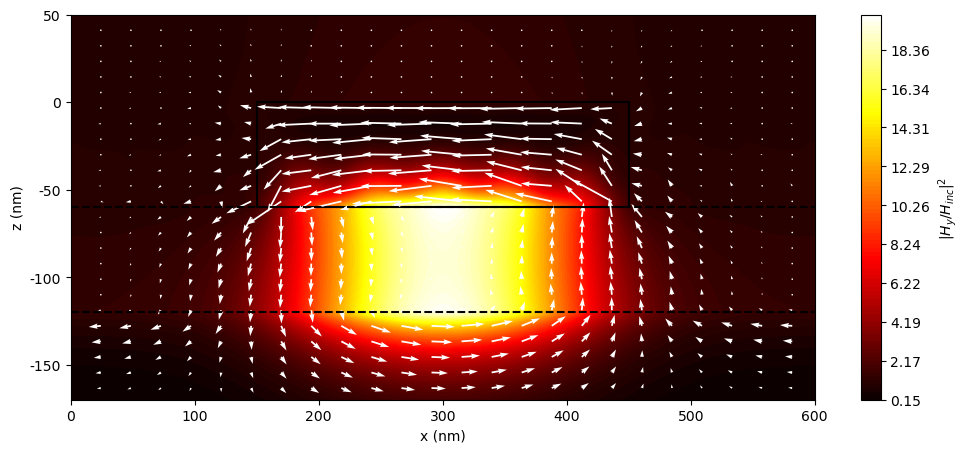

In [ ]:

z_min = .95
z_max = 1.17
z_space = np.linspace(z_min, z_max, 100)
magnetic_field = np.zeros((len(z_space), len(x_space), 3), dtype=complex)
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        _, H = S.GetFields(x, y_pt, z)  # y is 0
        magnetic_field[zi, xi, :] = np.array(H)
magnetic_field_magnitude = np.sum(np.abs(magnetic_field)**2, axis=2)
electric_field = np.zeros((len(z_space), len(x_space), 3), dtype=complex)
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        E, _ = S.GetFields(x, y_pt, z)  # y is 0
        electric_field[zi, xi, :] = np.array(E)
electric_field_magnitude = np.sum(np.abs(electric_field)**2, axis=2)
import matplotlib.patches as patches
plt.figure(figsize=(12, 5))
background = np.abs(magnetic_field[:, :, 1])**2
levels = np.linspace(np.min(background), np.max(background), 100)
cf1 = plt.contourf(x_space, z_space, background, levels=levels, cmap='hot')
plt.xlabel("x (nm)", labelsize=18)
plt.ylabel("z (nm)", labelsize=18)

plt.axhline(y=1.06, color='black', linestyle='--', linewidth=1.5)
plt.axhline(y=1.12, color='black', linestyle='--', linewidth=1.5)

plt.xlim(x_space[0], x_space[-1])
plt.ylim(z_max, z_min)
plt.xticks(np.arange(0,.7,.1), np.arange(0, 700, 100))
plt.yticks(np.arange(.95,1.175,.05), np.arange(50, -200, -50))
# plt.colorbar(cf1, label=r"$|M|^2$ (a.u.)")
cbar = plt.colorbar(cf1)
cbar.set_label(r"$|H_y/H_{inc}|^2$", fontsize=12)

ax = plt.gca()
# Replace the top horizontal line with a box for the Air region.
# The box spans from x = 0 to 0.15 and from z = 0.5 to z = 1.
air_box = patches.Rectangle((.15, 1.0), .3, 0.06, 
                             fill=False, edgecolor='black', linewidth=1.5)
ax.add_patch(air_box)

dz = z_space[1] - z_space[0]
dx = x_space[1] - x_space[0]
curlH = np.zeros_like(magnetic_field, dtype = complex)

dHx_dz, dHx_dx = np.gradient(magnetic_field[...,0], dz, dx, axis=(0,1))
dHy_dz, dHy_dx = np.gradient(magnetic_field[...,1], dz, dx, axis=(0,1))
dHz_dz, dHz_dx = np.gradient(magnetic_field[...,2], dz, dx, axis=(0,1))

curlH[...,0] = -dHy_dz
curlH[...,1] = dHx_dz - dHz_dx
curlH[...,2] = -dHy_dx

omega = 2 * np.pi * 1 / wavelength.item()
eps0 = 8.854187817e-12
eps = np.ones(shape = (z_space.shape[0], x_space.shape[0], 3))
for iz, z in enumerate(z_space):
    if z > 1.06 and z < 1.12:
        eps[iz,:] *= (SiO2_n[int(wavelength*1e3)]**2)
    if z > 1.12 and z < 2.12:
        eps[iz,:] *= np.real((w_n[i])**2)
    if z > 1 and z < 1.06:
        if x > 0.15 and x < 0.45:
            eps[iz,:] *= np.real((w_n[i])**2)

J = curlH - 1j * omega * eps0 * eps * electric_field
skip = 4
Z, X = np.meshgrid(z_space, x_space, indexing='ij')

plt.quiver(X[::skip, ::skip],
           Z[::skip, ::skip],
           np.real(J[::skip, ::skip, 0]),  # Jx
           np.real(J[::skip, ::skip, 2]),  # Jz
           color='white', scale=1e3)

plt.plot();

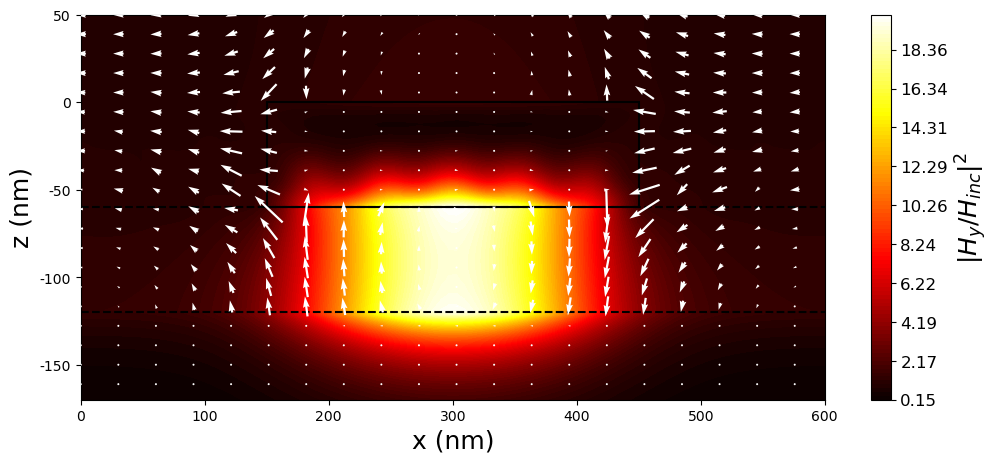

In [193]:

import matplotlib.patches as patches
plt.figure(figsize=(12, 5))
background = np.abs(magnetic_field[:, :, 1])**2
levels = np.linspace(np.min(background), np.max(background), 100)
cf1 = plt.contourf(x_space, z_space, background, levels=levels, cmap='hot')
plt.xlabel("x (nm)", fontsize=18)
plt.ylabel("z (nm)", fontsize=18)

plt.axhline(y=1.06, color='black', linestyle='--', linewidth=1.5)
plt.axhline(y=1.12, color='black', linestyle='--', linewidth=1.5)

plt.xlim(x_space[0], x_space[-1])
plt.ylim(z_max, z_min)
plt.xticks(np.arange(0,.7,.1), np.arange(0, 700, 100))
plt.yticks(np.arange(.95,1.175,.05), np.arange(50, -200, -50))
# plt.colorbar(cf1, label=r"$|M|^2$ (a.u.)")
cbar = plt.colorbar(cf1)
cbar.set_label(r"$|H_y/H_{inc}|^2$", fontsize=18)
cbar.ax.tick_params(labelsize=12)

ax = plt.gca()
# Replace the top horizontal line with a box for the Air region.
# The box spans from x = 0 to 0.15 and from z = 0.5 to z = 1.
air_box = patches.Rectangle((.15, 1.0), .3, 0.06, 
                             fill=False, edgecolor='black', linewidth=1.5)
ax.add_patch(air_box)

skip = 5
Z, X = np.meshgrid(z_space, x_space, indexing='ij')
plt.quiver(X[::skip, ::skip], Z[::skip, ::skip],
           np.real(electric_field[::skip, ::skip, 0]), np.real(electric_field[::skip, ::skip, 2]),
           color='white', scale=100, zorder=10, pivot='mid')

plt.plot();

Loaded logs/config_92e5a9ca/emission.npy with shape (2649,)
Loaded logs/rotated-single-dim-config_74f0ee63/emission.npy with shape (2649,)
Loaded logs/rotated-single-dim-config_5fae69b7/emission.npy with shape (2649,)


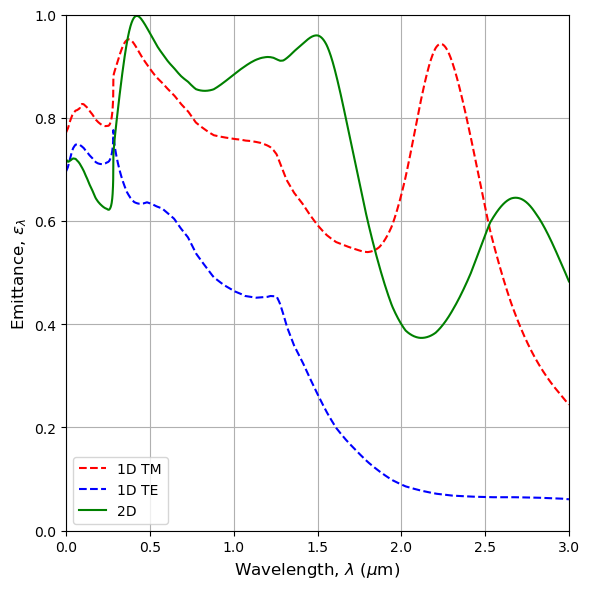

In [73]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Define the paths to the three folders
paths = [
    "logs/config_92e5a9ca",
    "logs/rotated"  # We'll handle finding the rotated folders dynamically
]

# Find all "rotated" folders
rotated_folders = []
rotated_base = Path("logs")
for item in rotated_base.glob("rotated*"):
    if item.is_dir():
        rotated_folders.append(item)

# Make sure we have at least 2 rotated folders
if len(rotated_folders) < 2:
    print(f"Warning: Expected at least 2 rotated folders, found {len(rotated_folders)}")

# Final paths list
all_paths = [Path("logs/config_92e5a9ca")] + rotated_folders[:2]

# Load the emission.npy files
emissions = []
labels = []

for path in all_paths:
    emission_file = path / "emission.npy"
    if emission_file.exists():
        data = np.load(emission_file)
        emissions.append(data)
        labels.append(path.name)
        print(f"Loaded {emission_file} with shape {data.shape}")
    else:
        print(f"Could not find {emission_file}")

# If you want explicit labels like the second figure (1D TM, 1D TE, 2D, Plain Tungsten), define them here.
# If you only have 3 data sets, just define 3 labels below.
plot_labels = ["1D TM", "1D TE", "2D", "Plain Tungsten"]

# Define custom line styles to mimic the second figure’s style:
#   1) 1D TM: red dashed
#   2) 1D TE: blue dashed
#   3) 2D: green solid
#   4) Plain tungsten: black dash-dot
line_styles = [
    {'color': 'red',   'linestyle': '--'},
    {'color': 'blue',  'linestyle': '--'},
    {'color': 'green', 'linestyle': '-'},
    {'color': 'black', 'linestyle': '-.'}
]

# Plot the emissions in the style of the second figure
if emissions:
    plt.figure(figsize=(6, 6))

    for i, emission in enumerate(emissions):
        # Create an x array that goes from 0 to 3 (microns) matching the length of your emission data
        # so we can label the x-axis as wavelength in microns.
        x = np.linspace(0, 3, len(emission))
        
        # If the data is 2D, you might want to average over one axis:
        if len(emission.shape) == 2:
            # For example, average over the second dimension
            emission = emission.mean(axis=1)
        
        # Safely pick a style from the list, in case you have fewer or more datasets
        style = line_styles[i % len(line_styles)]
        
        # Likewise pick a label from the custom label list (or use folder names if preferred)
        label = plot_labels[i] if i < len(plot_labels) else labels[i]
        
        plt.plot(x, emission, label=label, **style)

    # Style the plot to mimic the second figure
    plt.xlabel(r"Wavelength, $\lambda$ ($\mu$m)", fontsize=12)
    plt.ylabel(r"Emittance, $\epsilon_{\lambda}$", fontsize=12)
    
    # Match the x-range of the second figure (0 to 3 µm), and y-range (0 to ~1)
    plt.xlim(0, 3)
    plt.ylim(0, 1)
    
    # Set custom ticks to mimic the second figure
    plt.xticks(np.arange(0, 3.1, 0.5))
    plt.yticks(np.arange(0, 1.1, 0.2))
    
    # Add a grid
    plt.grid(True)
    
    # Place the legend
    plt.legend(loc='lower left', fontsize=10)
    
    # Remove the main title to match the second figure (or comment out if you want to keep it)
    # plt.title("Emittance vs Wavelength")

    plt.tight_layout()
    plt.savefig("emission_comparison.png")
    plt.show()

else:
    print("No emission data found to plot")


Loaded logs/config_92e5a9ca/emission.npy with shape (2649,)
Loaded logs/rotated-single-dim-config_d56872ef/emission.npy with shape (2649,)
Loaded logs/rotated-single-dim-config_37d76962/emission.npy with shape (349,)


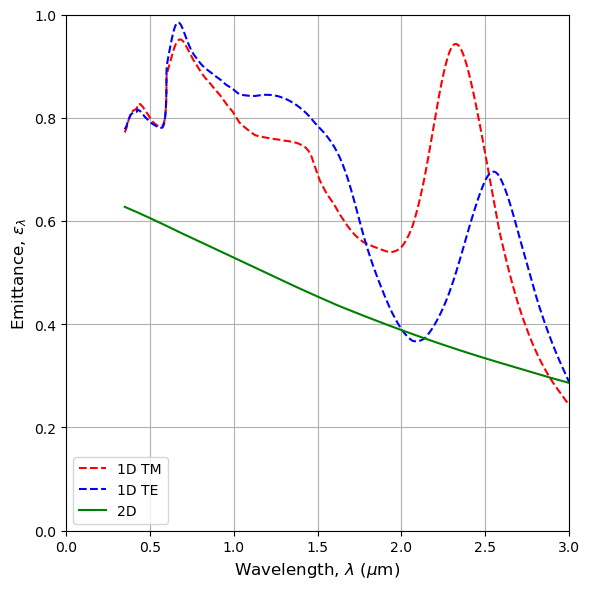

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Define the paths to the three folders
paths = [
    "logs/config_92e5a9ca",
    "logs/rotated"  # We'll handle finding the rotated folders dynamically
]

# Find all "rotated" folders
rotated_folders = []
rotated_base = Path("logs")
for item in rotated_base.glob("rotated*"):
    if item.is_dir():
        rotated_folders.append(item)

# Make sure we have at least 2 rotated folders
if len(rotated_folders) < 2:
    print(f"Warning: Expected at least 2 rotated folders, found {len(rotated_folders)}")

# Final paths list
all_paths = [Path("logs/config_92e5a9ca")] + rotated_folders[:2]

# Load the emission.npy files
emissions = []
labels = []

for path in all_paths:
    emission_file = path / "emission.npy"
    if emission_file.exists():
        data = np.load(emission_file)
        emissions.append(data)
        labels.append(path.name)
        print(f"Loaded {emission_file} with shape {data.shape}")
    else:
        print(f"Could not find {emission_file}")

# If you want explicit labels like the second figure (1D TM, 1D TE, 2D, Plain Tungsten), define them here.
# If you only have 3 data sets, just define 3 labels below.
plot_labels = ["1D TM", "1D TE", "2D", "Plain Tungsten"]

# Define custom line styles to mimic the second figure's style:
#   1) 1D TM: red dashed
#   2) 1D TE: blue dashed
#   3) 2D: green solid
#   4) Plain tungsten: black dash-dot
line_styles = [
    {'color': 'red',   'linestyle': '--'},
    {'color': 'blue',  'linestyle': '--'},
    {'color': 'green', 'linestyle': '-'},
    {'color': 'black', 'linestyle': '-.'}
]

# Plot the emissions in the style of the second figure
if emissions:
    plt.figure(figsize=(6, 6))

    for i, emission in enumerate(emissions):
        # Create an x array that starts at 0.35 and goes to 3 microns matching the length of your emission data
        x = np.linspace(0.35, 3, len(emission))
        
        # If the data is 2D, you might want to average over one axis:
        if len(emission.shape) == 2:
            # For example, average over the second dimension
            emission = emission.mean(axis=1)
        
        # Safely pick a style from the list, in case you have fewer or more datasets
        style = line_styles[i % len(line_styles)]
        
        # Likewise pick a label from the custom label list (or use folder names if preferred)
        label = plot_labels[i] if i < len(plot_labels) else labels[i]
        
        plt.plot(x, emission, label=label, **style)

    # Style the plot to mimic the second figure
    plt.xlabel(r"Wavelength, $\lambda$ ($\mu$m)", fontsize=12)
    plt.ylabel(r"Emittance, $\epsilon_{\lambda}$", fontsize=12)
    
    # Match the x-range of the second figure (0 to 3 µm), and y-range (0 to ~1)
    plt.xlim(0, 3)
    plt.ylim(0, 1)
    
    # Set custom ticks to mimic the second figure
    plt.xticks(np.arange(0, 3.1, 0.5))
    plt.yticks(np.arange(0, 1.1, 0.2))
    
    # Add a grid
    plt.grid(True)
    
    # Place the legend
    plt.legend(loc='lower left', fontsize=10)
    
    # Remove the main title to match the second figure (or comment out if you want to keep it)
    # plt.title("Emittance vs Wavelength")

    plt.tight_layout()
    plt.savefig("emission_comparison.png")
    plt.show()

else:
    print("No emission data found to plot")


In [179]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.interpolate import interp1d
import os
from pathlib import Path
import ff

h = 6.626070e-34  # Js Planck's constant
c = 2.997925e8  # m/s speed of light
k_B = 1.380649e-23  # J/K Boltzmann constant
q = 1.602176e-19  # C elementary charge
e_0 = 8.8541878128e-12

def Blackbody(lambda_i, T):
    return (2*h*c**2) / ((np.exp((h*c)/(k_B*T*lambda_i*1e-6))-1)*lambda_i**5)*1e14

T_PV = 300  # K PV temperature
T_e = 2073.15  # K emitter temperature

def nb_B(lambda_i, T):
    return (2*c) / ((np.exp((h*c)/(k_B*T*lambda_i*1e-6))-1)*lambda_i**4)*1e8
nb_B_e = nb_B(wavelengths, T_e)  # 2073.15K photon

nb_B_PV = nb_B(wavelengths, T_PV)  # 300K photon

def IQE(wavelength, e_g):
    lambda_g = np.ceil(1240 / e_g) / 1000.0

    if (lambda_g > wavelength[-1]):
        l_index = wavelength[-1]
    else:
        l_index = torch.where(wavelength >= lambda_g)[0][0]
    IQE = torch.ones(len(wavelength))
    for i in range(l_index, len(wavelength)):
        IQE[i] = 0
    return IQE


def JV(em, IQE, lambda_i):
    em = em.squeeze()
    J_L = ff.q * torch.sum(em * nb_B_e * IQE) * (lambda_i[1] - lambda_i[0])
    J_0 = ff.q * torch.sum(nb_B_PV*IQE) * (lambda_i[1] - lambda_i[0])

    V_oc = (ff.k_B*ff.T_PV/ff.q)*torch.log(J_L/J_0+1)
    t = torch.linspace(0, 1, 100)
    V = t * V_oc

    J = J_L-J_0*(torch.exp(ff.q*V/(ff.k_B*ff.T_PV))-1)
    P = V*J

    return torch.max(P)


def power_ratio(lambda_i, emissivity_dataset, T_emitter, E_g_PV):
    emissivity = emissivity_dataset.squeeze()
    P_emit = torch.sum(emissivity*Blackbody(lambda_i, T_emitter)
                       ) * (lambda_i[1] - lambda_i[0])
    IQE_PV = IQE(lambda_i, E_g_PV)
    JV_PV = JV(emissivity, IQE_PV, lambda_i)

    FOM = JV_PV / P_emit
    return FOM
# Load the emission data
data_path = "aln-logs/rotated-single-dim-config_7e9a99ec/emission.npy"
emission_data = np.load(data_path)

# Let's determine the shape and structure of the data
print(f"Emission data shape: {emission_data.shape}")

# Assuming the data is structured with wavelengths every 20 nm
# Create the original wavelength array (every 20 nm)
original_wavelengths = np.arange(350, 3001, 20)  # Assuming the range from 350 to 3000 nm

# Create a new wavelength array with every 1 nm
new_wavelengths = np.arange(350, 2990)

# Check if shapes align
if len(original_wavelengths) != emission_data.shape[0]:
    print(f"Warning: Data length ({emission_data.shape[0]}) doesn't match expected wavelength points ({len(original_wavelengths)})")
    # Adjust the original_wavelengths if needed
    original_wavelengths = np.linspace(350, 3000, emission_data.shape[0])

# Create interpolation function
interpolation_func = interp1d(original_wavelengths, emission_data, axis=0, kind='linear')

# Generate interpolated data
interpolated_emission = interpolation_func(new_wavelengths)
interpolated_emission = np.concat([interpolated_emission, interpolated_emission[-9:]])

lambda_torch = torch.tensor(np.arange(350, 2999), dtype=torch.float32)
emission_torch = torch.tensor(interpolated_emission, dtype=torch.float32)

# Example parameters (adjust as needed)
T_emitter = 1500  # Temperature in Kelvin
E_g_PV = 0.6      # Bandgap energy in eV

# Calculate and print the power ratio
fom = power_ratio(lambda_torch, emission_torch, T_emitter, E_g_PV)
print(f"Power Ratio (Figure of Merit): {fom.item():.4f}")

Emission data shape: (133,)
Power Ratio (Figure of Merit): nan


/tmp/ipykernel_310949/311999941.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (2*c) / ((np.exp((h*c)/(k_B*T*lambda_i*1e-6))-1)*lambda_i**4)*1e8
/tmp/ipykernel_310949/311999941.py:22: RuntimeWarning: overflow encountered in exp
  return (2*c) / ((np.exp((h*c)/(k_B*T*lambda_i*1e-6))-1)*lambda_i**4)*1e8
/tmp/ipykernel_310949/311999941.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (2*h*c**2) / ((np.exp((h*c)/(k_B*T*lambda_i*1e-6))-1)*lambda_i**5)*1e14


In [53]:
import torch
h = 6.626070e-34  # Js Planck's constant
c = 2.997925e8  # m/s speed of light
k_B = 1.380649e-23  # J/K Boltzmann constant
q = 1.602176e-19  # C elementary charge
e_0 = 8.8541878128e-12


def Blackbody(lambda_i, T):
    return (2*h*c**2) / ((torch.exp((h*c)/(k_B*T*lambda_i*1e-6))-1)*lambda_i**5)*1e14


def nb_B(lambda_i, T):
    return (2*c) / ((torch.exp((h*c)/(k_B*T*lambda_i*1e-6))-1)*lambda_i**4)*1e8


wavelengths = torch.linspace(.350, 3, 2651)  # Issue when this goes past 99?
# [::100] # This is necessary due to S4 bugging out at these wavelengths
wavelengths = wavelengths[(wavelengths != 0.5) & (wavelengths != 1.0)]
T_e = 2073.15  # K emitter temperature
nb_B_e = nb_B(wavelengths, T_e)  # 2073.15K photon
T_PV = 300  # K PV temperature
nb_B_PV = nb_B(wavelengths, T_PV)  # 300K photon


def IQE(wavelength, e_g):
    lambda_g = np.ceil(1240 / e_g) / 1000.0

    if (lambda_g > wavelength[-1]):
        l_index = wavelength[-1]
    else:
        l_index = torch.where(wavelength >= lambda_g)[0][0]
    IQE = torch.ones(len(wavelength))
    for i in range(l_index, len(wavelength)):
        IQE[i] = 0
    return IQE


def JV(em, IQE, lambda_i):
    em = em.squeeze()
    J_L = q * torch.sum(em * nb_B_e * IQE) * (lambda_i[1] - lambda_i[0])
    J_0 = q * torch.sum(nb_B_PV*IQE) * (lambda_i[1] - lambda_i[0])

    V_oc = (k_B*T_PV/q)*torch.log(J_L/J_0+1)
    t = torch.linspace(0, 1, 100)
    V = t * V_oc

    J = J_L-J_0*(torch.exp(q*V/(k_B*T_PV))-1)
    P = V*J

    return torch.max(P)


def power_ratio(lambda_i, emissivity_dataset, T_emitter, E_g_PV):
    emissivity = emissivity_dataset.squeeze()
    P_emit = torch.sum(emissivity*Blackbody(lambda_i, T_emitter)
                       ) * (lambda_i[1] - lambda_i[0])
    IQE_PV = IQE(lambda_i, E_g_PV)
    JV_PV = JV(emissivity, IQE_PV, lambda_i)

    FOM = JV_PV / P_emit
    return FOM

# print(power_ratio(torch.linspace(.350, 3, 2649), torch.tensor(interpolated_emission), T_e, .726))

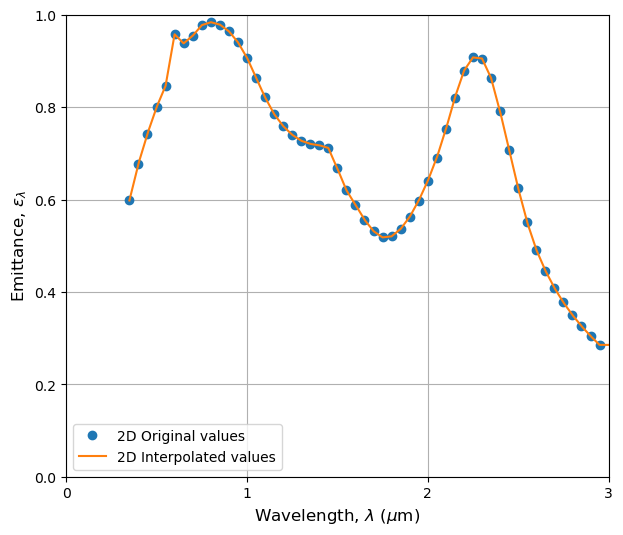

Number of original non-zero values: 53
Number of interpolated values: 2649
tensor(0.3166, dtype=torch.float64)


In [56]:
# Let's say x is your array with zeros at indices not divisible by 50
x = np.load("new-logs/rotated-single-dim-config_7e9a99ec/emission.npy")
# Get the indices for meaningful values (divisible by 50)
valid_indices = np.arange(0, len(x), 50)
valid_values = x[valid_indices]

# Create a full range of indices
all_indices = np.arange(len(x))

# Perform linear interpolation
interpolated_values = np.interp(all_indices, valid_indices, valid_values)

# Plot the original and interpolated data
plt.figure(figsize=(7, 6))
plt.plot(valid_indices+350, valid_values, 'o', label='2D Original values')
plt.plot(all_indices+350, interpolated_values, '-', label='2D Interpolated values')
plt.xlabel(r"Wavelength, $\lambda$ ($\mu$m)", fontsize=12)
plt.ylabel(r"Emittance, $\epsilon_{\lambda}$", fontsize=12)

# Match the x-range of the second figure (0 to 3 µm), and y-range (0 to ~1)
plt.xlim(0, 3000)
plt.ylim(0, 1)

# Set custom ticks to mimic the second figure
plt.xticks(np.arange(0, 4000, 1000), np.arange(0, 4, 1))
# plt.yticks(np.arange(0, 1.1, 0.2))
plt.legend()
plt.grid(True)
plt.show()

print(f"Number of original non-zero values: {len(valid_values)}")
print(f"Number of interpolated values: {len(interpolated_values)}")
print(power_ratio(torch.linspace(.350, 3, 2649), torch.tensor(interpolated_values), T_e, .726))

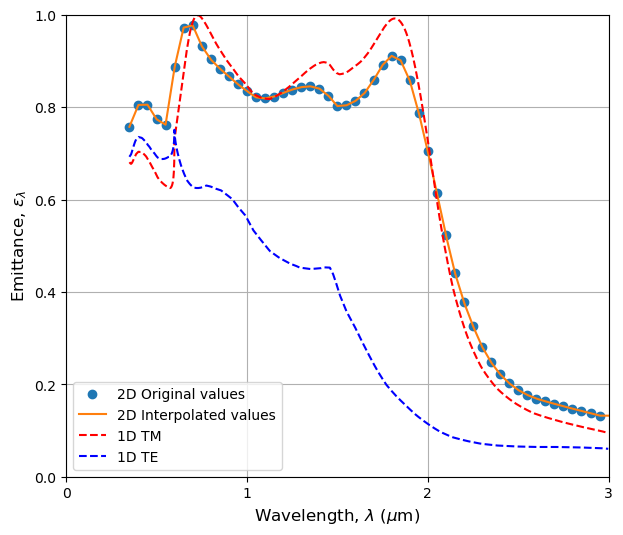

Number of original non-zero values: 53
Number of interpolated values: 2649


In [49]:
# Let's say x is your array with zeros at indices not divisible by 50
x = np.load("new-logs/rotated-single-dim-config_7e9a99ec/emission.npy")
tm = np.load('new-logs/rotated-single-dim-config_b1f8910f/emission.npy')
te = np.load('new-logs/rotated-single-dim-config_03f31140/emission.npy')
# Get the indices for meaningful values (divisible by 50)
valid_indices = np.arange(0, len(x), 50)
valid_values = x[valid_indices]

# Create a full range of indices
all_indices = np.arange(len(x))

# Perform linear interpolation
interpolated_values = np.interp(all_indices, valid_indices, valid_values)

# Plot the original and interpolated data
plt.figure(figsize=(7, 6))
plt.plot(valid_indices+350, valid_values, 'o', label='2D Original values')
plt.plot(all_indices+350, interpolated_values, '-', label='2D Interpolated values')
plt.plot(all_indices+350, tm, '--', label = '1D TM', color = 'r')
plt.plot(all_indices+350, te, '--', label = '1D TE', color = 'b')
plt.xlabel(r"Wavelength, $\lambda$ ($\mu$m)", fontsize=12)
plt.ylabel(r"Emittance, $\epsilon_{\lambda}$", fontsize=12)

# Match the x-range of the second figure (0 to 3 µm), and y-range (0 to ~1)
plt.xlim(0, 3000)
plt.ylim(0, 1)

# Set custom ticks to mimic the second figure
plt.xticks(np.arange(0, 4000, 1000), np.arange(0, 4, 1))
# plt.yticks(np.arange(0, 1.1, 0.2))
plt.legend()
plt.grid(True)
plt.show()

print(f"Number of original non-zero values: {len(valid_values)}")
print(f"Number of interpolated values: {len(interpolated_values)}")

Creating S4 simulation...
Testing GetFields (point-by-point)...
GetFields time: 0.0124 seconds
Testing GetFieldsOnGrid...
GetFieldsOnGrid time: 0.0005 seconds
Maximum difference: 0.980392281841689
Mean difference: 0.16969005261991307
Speed improvement: 26.38x faster


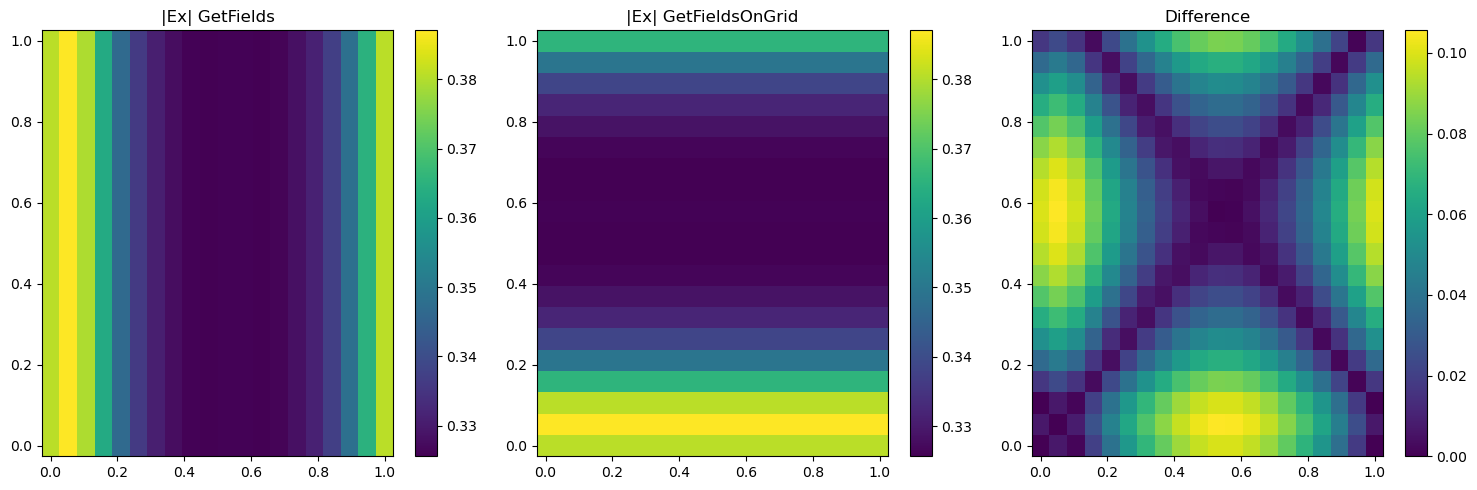

In [13]:
"""
Test comparing S4's GetFields vs GetFieldsOnGrid functions
"""

import os
import time
import numpy as np
import torch
import S4
import matplotlib.pyplot as plt

# Configuration
wavelength = 1.5  # Single wavelength for testing
num_image_squares = 10
grid_thickness = 0.473
vacuum_thickness = 0.5
image_harmonics = 10

# Create grid for testing
nx, ny = 20, 20  # Grid dimensions
x_min, x_max = 0, 1
y_min, y_max = 0, 1
z_value = vacuum_thickness + 0.1  # Z-position to evaluate fields

x_grid = np.linspace(x_min, x_max, nx)
y_grid = np.linspace(y_min, y_max, ny)

# Material properties - using arbitrary values since original ff module isn't available
n_aln = 2.0 + 0.0j
n_w = 3.5 + 0.5j

# Create a single S4 simulation
print("Creating S4 simulation...")
S = S4.New(Lattice=1, NumBasis=image_harmonics)
S.SetOptions(LanczosSmoothing=True)

# Set materials
S.SetMaterial(Name='W', Epsilon=n_w**2)
S.SetMaterial(Name='Vacuum', Epsilon=(1 + 0j)**2)
S.SetMaterial(Name='AlN', Epsilon=n_aln**2)

# Add layers
S.AddLayer(Name='VacuumAbove', Thickness=vacuum_thickness, Material='Vacuum')
S.AddLayer(Name='Grid', Thickness=grid_thickness, Material='Vacuum')

# Create a pattern in the grid
for q in range(num_image_squares):
    material_value = 0.5 + 0.5 * np.sin(q * np.pi / num_image_squares)
    S.SetMaterial(Name=f'Grid material {q}', Epsilon=material_value * (n_aln**2 - 1) + 1)
    S.SetRegionRectangle(
        Layer='Grid',
        Material=f'Grid material {q}',
        Center=((q+1)/num_image_squares - 1/(2*num_image_squares), 0.5),
        Halfwidths=(1/(2*num_image_squares), 0.5),
        Angle=0
    )

S.AddLayer(Name='Absorber', Thickness=1.0, Material='W')

# Set plane wave excitation
S.SetExcitationPlanewave(
    IncidenceAngles=(0, 0),
    sAmplitude=1/np.sqrt(2),
    pAmplitude=1/np.sqrt(2),
    Order=0
)

# Set the wavelength
S.SetFrequency(1 / wavelength)

# Test 1: GetFields (point by point)
print("Testing GetFields (point-by-point)...")
start_time = time.time()
fields_individual = np.zeros((nx, ny, 3), dtype=complex)

for i, x in enumerate(x_grid):
    for j, y in enumerate(y_grid):
        fields_individual[i, j] = S.GetFields(x, y, z_value)[0]

get_fields_time = time.time() - start_time
print(f"GetFields time: {get_fields_time:.4f} seconds")

# Test 2: GetFieldsOnGrid
print("Testing GetFieldsOnGrid...")
start_time = time.time()
fields_grid = S.GetFieldsOnGrid(z_value, NumSamples=(nx, ny), Format='Array')[0] # Electric field
get_fields_grid_time = time.time() - start_time
print(f"GetFieldsOnGrid time: {get_fields_grid_time:.4f} seconds")

# Compute difference
fields_grid_reshaped = np.array(fields_grid)
    
# Calculate difference
difference = np.abs(fields_individual - fields_grid_reshaped)
max_diff = np.max(difference)
mean_diff = np.mean(difference)

print(f"Maximum difference: {max_diff}")
print(f"Mean difference: {mean_diff}")
print(f"Speed improvement: {get_fields_time / get_fields_grid_time:.2f}x faster")

# Visualize field magnitude from both methods
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.pcolormesh(x_grid, y_grid, np.abs(fields_individual[:, :, 0]).T)
plt.colorbar()
plt.title('|Ex| GetFields')

plt.subplot(1, 3, 2)
plt.pcolormesh(x_grid, y_grid, np.abs(fields_grid_reshaped[:, :, 0]).T)
plt.colorbar()
plt.title('|Ex| GetFieldsOnGrid')

plt.subplot(1, 3, 3)
plt.pcolormesh(x_grid, y_grid, difference[:, :, 0].T)
plt.colorbar()
plt.title('Difference')

plt.tight_layout()
plt.savefig('GetFields_vs_GetFieldsOnGrid.png')
plt.show()


Creating S4 simulation...
Testing GetFields (point-by-point)...
GetFields time: 0.0196 seconds
Testing GetFieldsOnGrid...
GetFieldsOnGrid time: 0.0017 seconds
Maximum difference: 0.9804454385011989
Mean difference: 0.16802862141222466
Speed improvement: 11.56x faster


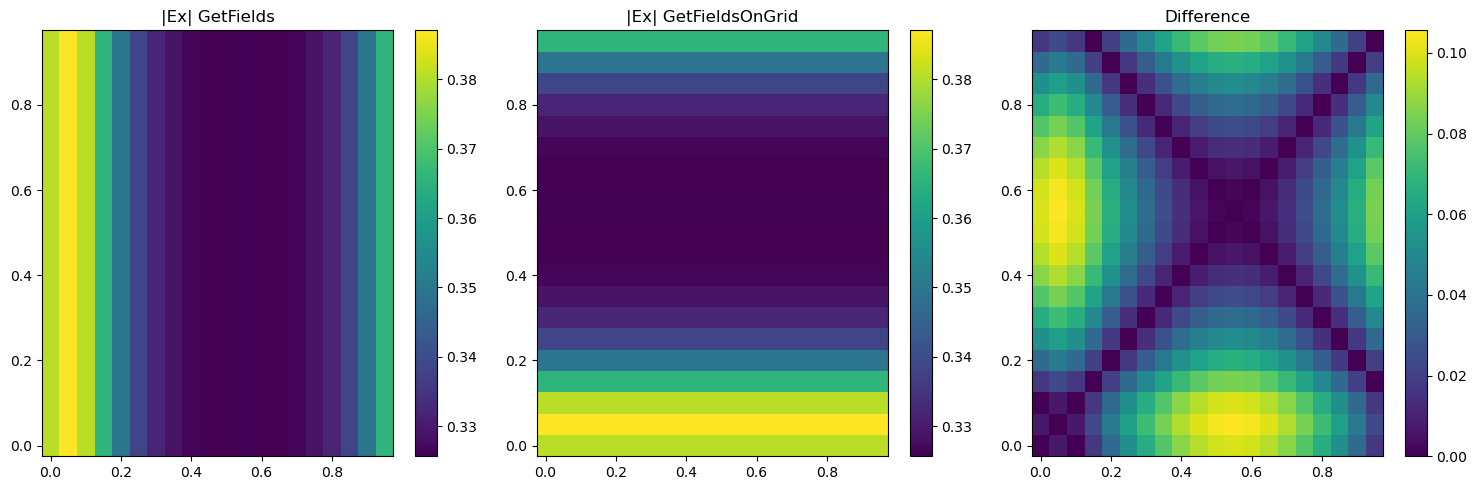

In [ ]:
"""
Test comparing S4's GetFields vs GetFieldsOnGrid functions
"""

import os
import time
import numpy as np
import S4
import matplotlib.pyplot as plt

# Configuration
wavelength = 1.5 # Single wavelength for testing
num_image_squares = 10
grid_thickness = 0.473
vacuum_thickness = 0.5
image_harmonics = 10

# Create grid for testing
nx, ny = 20, 20 # Grid dimensions
z_value = vacuum_thickness + 0.1 # Z-position to evaluate fields

# Material properties - using arbitrary values since original ff module isn't available
n_aln = 2.0 + 0.0j
n_w = 3.5 + 0.5j

# Create a single S4 simulation
print("Creating S4 simulation...")
S = S4.New(Lattice=1, NumBasis=image_harmonics)
S.SetOptions(LanczosSmoothing=True)

# Set materials
S.SetMaterial(Name='W', Epsilon=n_w**2)
S.SetMaterial(Name='Vacuum', Epsilon=(1 + 0j)**2)
S.SetMaterial(Name='AlN', Epsilon=n_aln**2)

# Add layers
S.AddLayer(Name='VacuumAbove', Thickness=vacuum_thickness, Material='Vacuum')
S.AddLayer(Name='Grid', Thickness=grid_thickness, Material='Vacuum')

# Create a pattern in the grid
for q in range(num_image_squares):
    material_value = 0.5 + 0.5 * np.sin(q * np.pi / num_image_squares)
    S.SetMaterial(Name=f'Grid material {q}', Epsilon=material_value * (n_aln**2 - 1) + 1)
    S.SetRegionRectangle(
        Layer='Grid',
        Material=f'Grid material {q}',
        Center=((q+1)/num_image_squares - 1/(2*num_image_squares), 0.5),
        Halfwidths=(1/(2*num_image_squares), 0.5),
        Angle=0
    )

S.AddLayer(Name='Absorber', Thickness=1.0, Material='W')

# Set plane wave excitation
S.SetExcitationPlanewave(
    IncidenceAngles=(0, 0),
    sAmplitude=1/np.sqrt(2),
    pAmplitude=1/np.sqrt(2),
    Order=0
)

# Set the wavelength
S.SetFrequency(1 / wavelength)

# Get the same points for both methods
# GetFieldsOnGrid uses points that span the unit cell evenly
# We need to generate the same grid for GetFields
x_grid = np.linspace(0, 1, nx, endpoint=False)  # Points from 0 to just under 1
y_grid = np.linspace(0, 1, ny, endpoint=False)  # Points from 0 to just under 1

# Test 1: GetFields (point by point)
print("Testing GetFields (point-by-point)...")
start_time = time.time()
fields_individual = np.zeros((nx, ny, 3), dtype=complex)

for i, x in enumerate(x_grid):
    for j, y in enumerate(y_grid):
        # Get electric field only
        E, _ = S.GetFields(x, y, z_value)
        fields_individual[i, j, 0] = E[0]  # Ex
        fields_individual[i, j, 1] = E[1]  # Ey
        fields_individual[i, j, 2] = E[2]  # Ez

get_fields_time = time.time() - start_time
print(f"GetFields time: {get_fields_time:.4f} seconds")

# Test 2: GetFieldsOnGrid
print("Testing GetFieldsOnGrid...")
start_time = time.time()
E_grid, _ = S.GetFieldsOnGrid(z_value, NumSamples=(nx, ny), Format='Array')
get_fields_grid_time = time.time() - start_time
print(f"GetFieldsOnGrid time: {get_fields_grid_time:.4f} seconds")

# Convert the grid result to a numpy array with the correct shape
# E_grid is returned as a tuple of dimension nu by nv, where each element is a 3-tuple
fields_grid_reshaped = np.zeros((nx, ny, 3), dtype=complex)
for i in range(nx):
    for j in range(ny):
        fields_grid_reshaped[i, j, 0] = E_grid[i][j][0]  # Ex
        fields_grid_reshaped[i, j, 1] = E_grid[i][j][1]  # Ey 
        fields_grid_reshaped[i, j, 2] = E_grid[i][j][2]  # Ez

# Compute difference
difference = np.abs(fields_individual - fields_grid_reshaped)
max_diff = np.max(difference)
mean_diff = np.mean(difference)

print(f"Maximum difference: {max_diff}")
print(f"Mean difference: {mean_diff}")
print(f"Speed improvement: {get_fields_time / get_fields_grid_time:.2f}x faster")

# Visualize field magnitude from both methods
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.pcolormesh(x_grid, y_grid, np.abs(fields_individual[:, :, 0]).T)
plt.colorbar()
plt.title('|Ex| GetFields')

plt.subplot(1, 3, 2)
plt.pcolormesh(x_grid, y_grid, np.abs(fields_grid_reshaped[:, :, 0]).T)
plt.colorbar()
plt.title('|Ex| GetFieldsOnGrid')

plt.subplot(1, 3, 3)
plt.pcolormesh(x_grid, y_grid, difference[:, :, 0].T)
plt.colorbar()
plt.title('Difference')

plt.tight_layout()
plt.savefig('GetFields_vs_GetFieldsOnGrid.png')
plt.show()


In [32]:
"""
Test comparing S4's GetFields vs GetFieldsOnGrid functions
"""

import os
import time
import numpy as np
import S4
import matplotlib.pyplot as plt

# Configuration
wavelength = 1.5
num_image_squares = 10
grid_thickness = 0.473
vacuum_thickness = 0.5
image_harmonics = 10

# Create grid for testing
nx, ny = 6, 5
z_value = vacuum_thickness + 0.25

# Material properties
n_aln = 2.0 + 0.0j
n_w = 3.5 + 0.5j

# Create simulation
print("Creating S4 simulation...")
S = S4.New(Lattice=((1, 0), (0, 1)), NumBasis=image_harmonics)  # Explicitly define the lattice
S.SetOptions(LanczosSmoothing=True)

# Set materials
S.SetMaterial(Name='W', Epsilon=n_w**2)
S.SetMaterial(Name='Vacuum', Epsilon=(1 + 0j)**2)
S.SetMaterial(Name='AlN', Epsilon=n_aln**2)

# Add layers
S.AddLayer(Name='VacuumAbove', Thickness=vacuum_thickness, Material='Vacuum')
S.AddLayer(Name='Grid', Thickness=grid_thickness, Material='Vacuum')

S.SetRegionRectangle(Layer = 'Grid', Material = 'AlN', Center = (0.5, 0.5), Halfwidths = (0.25, 0.25), Angle = 0)

S.AddLayer(Name='Absorber', Thickness=1.0, Material='W')

# Set plane wave excitation
S.SetExcitationPlanewave(
    IncidenceAngles=(0, 0),
    sAmplitude=1/np.sqrt(2),
    pAmplitude=1/np.sqrt(2),
    Order=0
)

# Set the wavelength
S.SetFrequency(1 / wavelength)

# Test 2: GetFieldsOnGrid first
print("Testing GetFieldsOnGrid...")
start_time = time.time()
E_grid, _ = S.GetFieldsOnGrid(z_value, NumSamples=(nx, ny), Format='Array')
E_grid = np.array(E_grid)
get_fields_grid_time = time.time() - start_time
print(f"GetFieldsOnGrid time: {get_fields_grid_time:.4f} seconds")

print("Testing GetFields (point-by-point)...")
start_time = time.time()
fields_individual = np.zeros((ny, nx, 3), dtype=complex)  # Note ny,nx order

x_grid = np.linspace(0, 1, nx, endpoint = False)
y_grid = np.linspace(0, 1, ny, endpoint = False)

for j, y in enumerate(y_grid):
    for i, x in enumerate(x_grid):
        # Sample in y-first, x-second order to match GetFieldsOnGrid
        E, _ = S.GetFields(x, y, z_value)
        fields_individual[j, i, 0] = E[0]  # Ex
        fields_individual[j, i, 1] = E[1]  # Ey
        fields_individual[j, i, 2] = E[2]  # Ez

get_fields_time = time.time() - start_time
print(f"GetFields time: {get_fields_time:.4f} seconds")

print(x_grid)
print(y_grid)

Creating S4 simulation...
Testing GetFieldsOnGrid...
GetFieldsOnGrid time: 0.0041 seconds
Testing GetFields (point-by-point)...
GetFields time: 0.0050 seconds
[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333]
[0.  0.2 0.4 0.6 0.8]


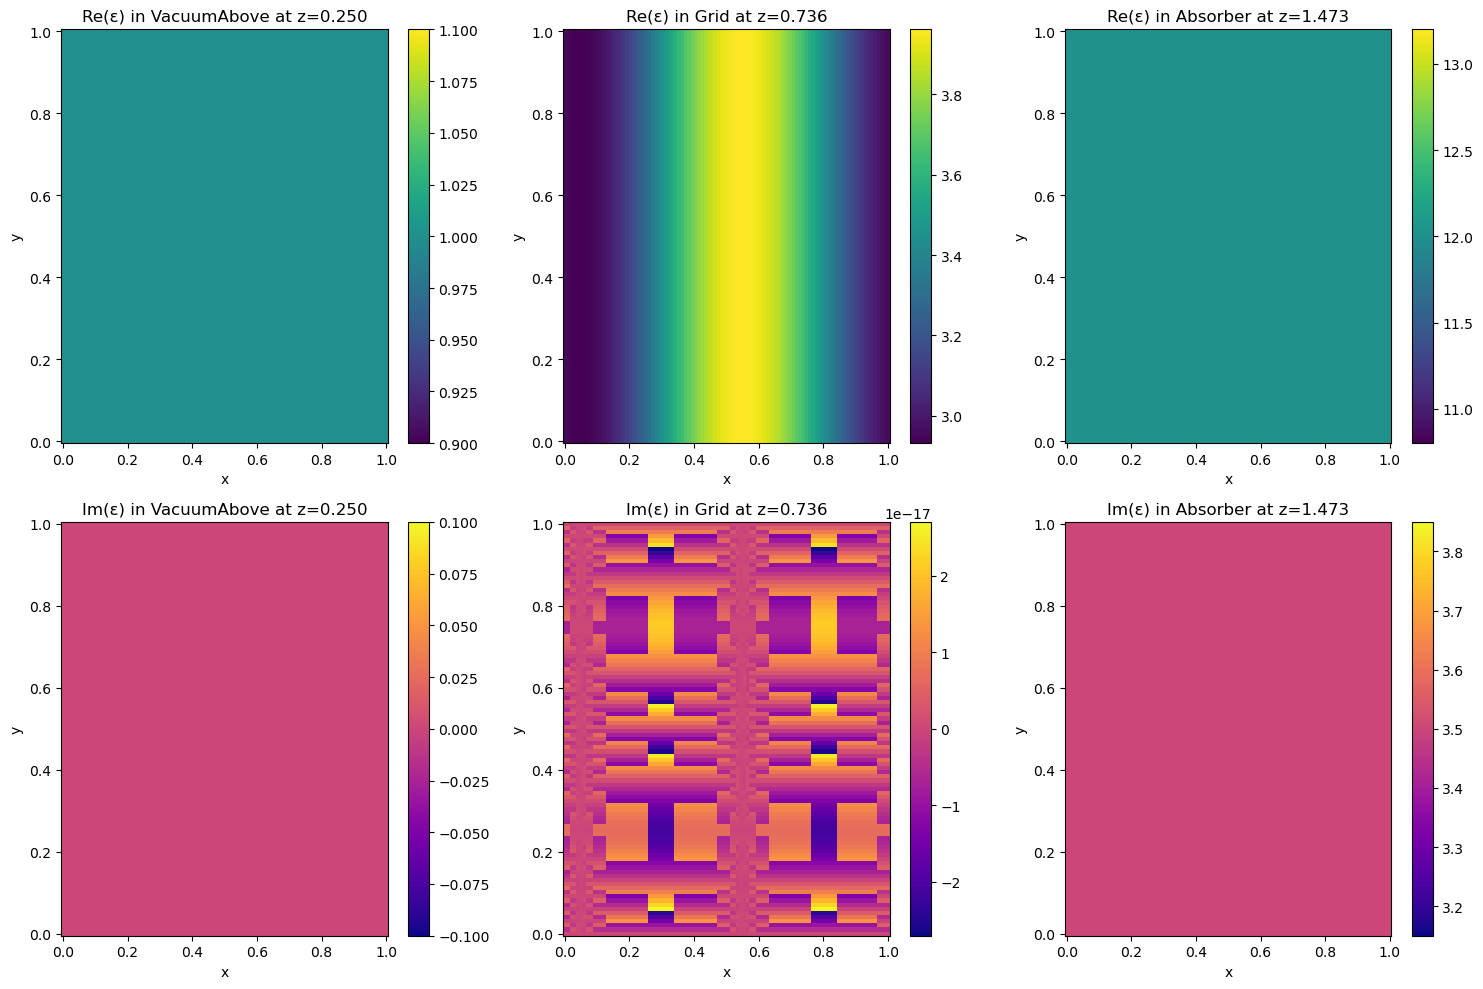

In [17]:
nx, ny = 100, 100  # Higher resolution for better visualization
x_grid = np.linspace(0, 1, nx)
y_grid = np.linspace(0, 1, ny)

# Create arrays for different z-slices
# We'll sample at three different depths:
# 1. In the vacuum layer
# 2. In the grid layer
# 3. In the absorber layer
z_positions = [
    vacuum_thickness/2,              # Middle of vacuum layer
    vacuum_thickness + grid_thickness/2,  # Middle of grid layer
    vacuum_thickness + grid_thickness + 0.5  # Middle of absorber layer
]
layer_names = ['VacuumAbove', 'Grid', 'Absorber']

# Create a figure with subplots for different z-slices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Sample permittivity at each position
for i, (z, layer_name) in enumerate(zip(z_positions, layer_names)):
    epsilon_real = np.zeros((nx, ny))
    epsilon_imag = np.zeros((nx, ny))
    
    for ix, x in enumerate(x_grid):
        for iy, y in enumerate(y_grid):
            epsilon = S.GetEpsilon(x, y, z)
            epsilon_real[ix, iy] = epsilon.real
            epsilon_imag[ix, iy] = epsilon.imag
    
    # Plot real part
    im1 = axes[0, i].pcolormesh(x_grid, y_grid, epsilon_real.T, cmap='viridis')
    axes[0, i].set_title(f'Re(ε) in {layer_name} at z={z:.3f}')
    axes[0, i].set_xlabel('x')
    axes[0, i].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0, i])
    
    # Plot imaginary part
    im2 = axes[1, i].pcolormesh(x_grid, y_grid, epsilon_imag.T, cmap='plasma')
    axes[1, i].set_title(f'Im(ε) in {layer_name} at z={z:.3f}')
    axes[1, i].set_xlabel('x')
    axes[1, i].set_ylabel('y')
    plt.colorbar(im2, ax=axes[1, i])

plt.tight_layout()
plt.savefig('permittivity_distribution.png', dpi=300)
plt.show()